این دیتاست شامل ویژگی‌های مختلفی است که می‌توانند برای پیش‌بینی بیماری قلبی استفاده شوند. برخی از ستون‌های مهم عبارتند از:

- **Age**: سن
- **Sex**: جنسیت (M برای مرد، F برای زن)
- **ChestPainType**: نوع درد قفسه سینه (مانند ATA، NAP، ASY)
- **RestingBP**: فشار خون در حالت استراحت
- **Cholesterol**: میزان کلسترول
- **FastingBS**: سطح قند خون ناشتا
- **RestingECG**: نتیجه ECG در حالت استراحت (Normal، ST)
- **MaxHR**: حداکثر ضربان قلب
- **ExerciseAngina**: آنژین ناشی از ورزش (Y یا N)
- **Oldpeak**: میزان کاهش ST
- **ST_Slope**: شیب بخش ST
- **HeartDisease**: نشان‌دهنده داشتن یا نداشتن بیماری قلبی (0 یا 1)


# Import libraries and dataset

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, roc_curve, auc
from imblearn.over_sampling import SMOTE

In [23]:
df = pd.read_csv('heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


# Data early review

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


# data preprocessing

In [25]:
# Replace zero values in 'Cholesterol' with the mean value
df['Cholesterol'] = df['Cholesterol'].replace(0, np.round(df['Cholesterol'].mean(), 2))
df['RestingBP'] = df['RestingBP'].replace(0, np.round(df['RestingBP'].mean(), 2))
df['FastingBS'] = df['FastingBS'].replace(0, np.round(df['FastingBS'].mean(), 2))

In [26]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.00,47.00,54.00,60.00,77.0
RestingBP,918.0,132.540741,17.989932,80.00,120.00,130.00,140.00,200.0
Cholesterol,918.0,236.047495,56.240898,85.00,198.80,223.00,267.00,603.0
FastingBS,918.0,0.409499,0.325745,0.23,0.23,0.23,0.23,1.0
MaxHR,918.0,136.809368,25.460334,60.00,120.00,138.00,156.00,202.0
Oldpeak,918.0,0.887364,1.066570,-2.60,0.00,0.60,1.50,6.2
HeartDisease,918.0,0.553377,0.497414,0.00,0.00,1.00,1.00,1.0


In [27]:
# Convert categorical columns to dummy variables
categorical_columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

In [28]:
df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140.0,289.0,0.23,172,0.0,0,True,True,False,False,True,False,False,False,True
1,49,160.0,180.0,0.23,156,1.0,1,False,False,True,False,True,False,False,True,False
2,37,130.0,283.0,0.23,98,0.0,0,True,True,False,False,False,True,False,False,True
3,48,138.0,214.0,0.23,108,1.5,1,False,False,False,False,True,False,True,True,False
4,54,150.0,195.0,0.23,122,0.0,0,True,False,True,False,True,False,False,False,True


In [29]:
# Split data into features and target
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

In [30]:
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

In [31]:
X.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140.0,289.0,0.23,172,0.0,True,True,False,False,True,False,False,False,True
1,49,160.0,180.0,0.23,156,1.0,False,False,True,False,True,False,False,True,False
2,37,130.0,283.0,0.23,98,0.0,True,True,False,False,False,True,False,False,True
3,48,138.0,214.0,0.23,108,1.5,False,False,False,False,True,False,True,True,False
4,54,150.0,195.0,0.23,122,0.0,True,False,True,False,True,False,False,False,True


In [32]:
y.head()

0    0
1    1
2    0
3    1
4    0
Name: HeartDisease, dtype: int64

# Correlation analysis

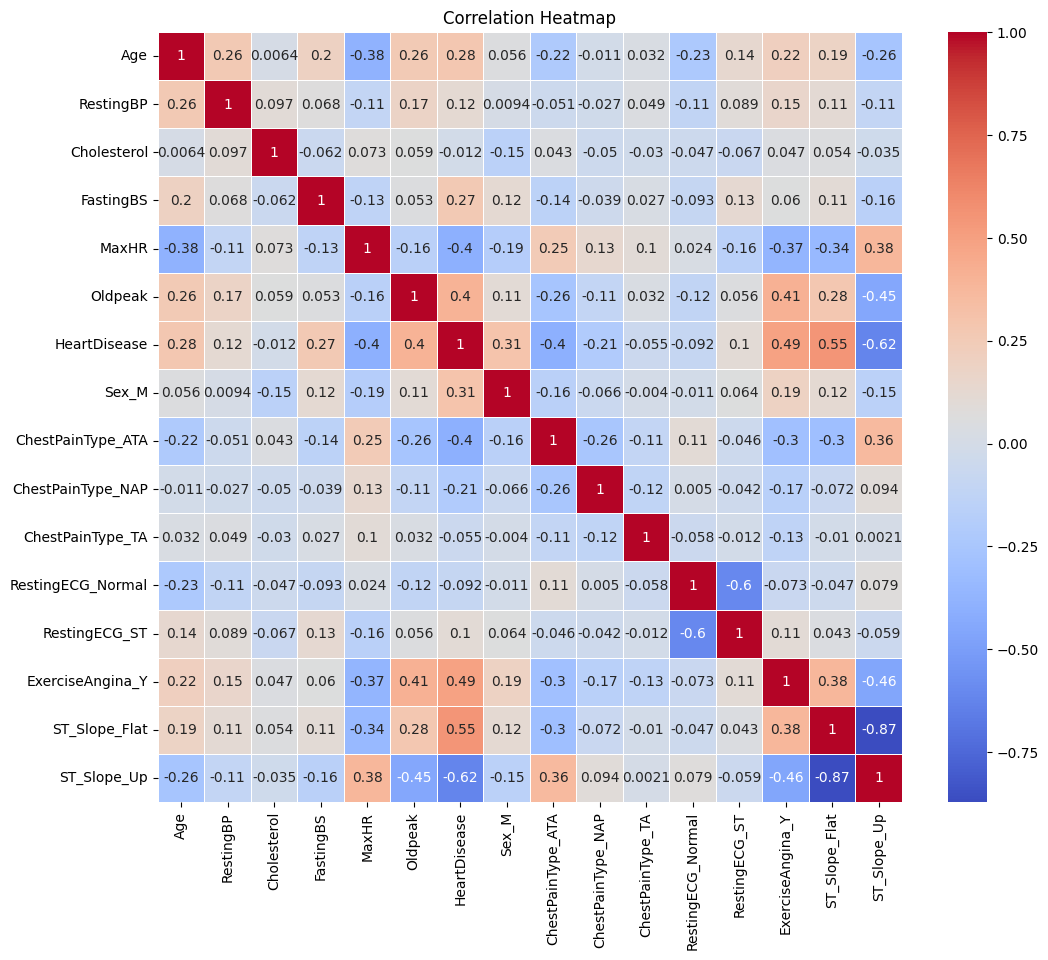

In [33]:
# correlation heatmap for understanding relationships
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Split the dataset into training and testing sets

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Feature scaling

In [35]:
# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#  Hyperparameter tuning for best model

In [36]:
# Hyperparameter tuning for best model
# Random Forest and SVM for comparison
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# GridSearchCV for RandomForestClassifier

In [37]:
# Perform GridSearchCV for RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, n_jobs=-1, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

# GridSearchCV for SVC

In [38]:
# Perform GridSearchCV for SVC
svc = SVC(probability=True, random_state=42)
grid_search_svc = GridSearchCV(svc, param_grid_svc, cv=5, n_jobs=-1, scoring='accuracy')
grid_search_svc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(probability=True, random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy')

# finding best model and best hyper parameters

In [39]:
# Choose the best model based on GridSearchCV results
best_model = grid_search_rf.best_estimator_ if grid_search_rf.best_score_ > grid_search_svc.best_score_ else grid_search_svc.best_estimator_

# Train the best model
best_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_split=10, random_state=42)

# Evaluating model

In [40]:
# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Best Model: {best_model}')
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(report)

Best Model: RandomForestClassifier(max_depth=10, min_samples_split=10, random_state=42)
Accuracy: 0.90
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       153
           1       0.92      0.88      0.90       152

    accuracy                           0.90       305
   macro avg       0.90      0.90      0.90       305
weighted avg       0.90      0.90      0.90       305



# confusion matrix

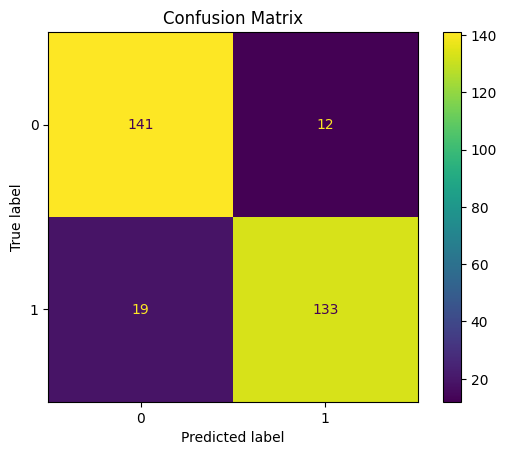

In [41]:
# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.title('Confusion Matrix')
plt.show()

# ROC curve

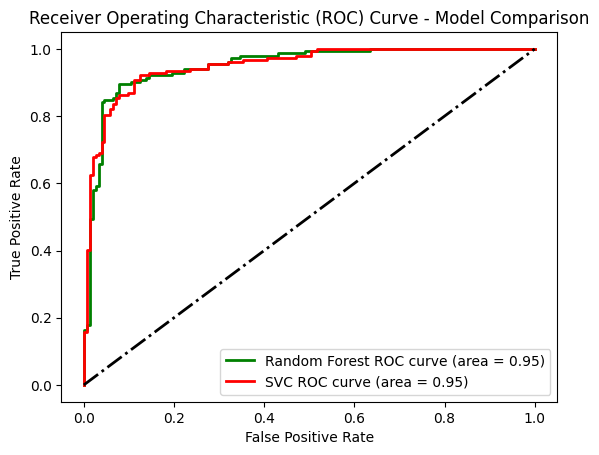

In [42]:
# ROC Curve
y_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# ROC Curve for SVC
y_prob_svc = grid_search_svc.best_estimator_.predict_proba(X_test)[:, 1]
fpr_svc, tpr_svc, _ = roc_curve(y_test, y_prob_svc)
roc_auc_svc = auc(fpr_svc, tpr_svc)

# Plotting all ROC curves for comparison
plt.figure()
# ROC Curve for RandomForestClassifier
y_prob_rf = grid_search_rf.best_estimator_.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Random Forest ROC curve (area = {roc_auc_rf:.2f})')
plt.plot(fpr_svc, tpr_svc, color='red', lw=2, label=f'SVC ROC curve (area = {roc_auc_svc:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='-.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Model Comparison')
plt.legend(loc='lower right')
plt.show()